#Fake News Detection with Machine Learning

##Introduction
Proyek ini bertujuan untuk membangun sistem deteksi berita palsu (*Fake News Detection*) menggunakan pendekatan **Natural Language Processing (NLP)** dan **Machine Learning**. Dengan dataset berita yang terdiri dari label *True* dan *Fake*, model dilatih untuk mengenali pola bahasa yang dapat membedakan informasi asli dengan hoaks.

##Objectives
1. Melakukan *exploratory data analysis (EDA)* untuk memahami distribusi dan karakteristik data.
2. Melakukan *feature engineering* berbasis teks (stopword removal, lemmatization, TF-IDF, dll).
3. Menerapkan beberapa algoritma ML seperti **Naive Bayes**, **Linear SVM**, dan **Logistic Regression**.
4. Mengevaluasi performa model menggunakan metrik **Accuracy, Precision, Recall, F1-Score, ROC-AUC, PR-AUC,** serta **Calibration Curve**.
5. Menentukan model terbaik yang dapat digunakan sebagai baseline untuk implementasi sistem deteksi berita palsu.

##Library Dependencies
Notebook ini menggunakan berbagai library Python untuk mendukung proses:
- **Data Processing**: Pandas, Numpy, Regex, Scipy
- **Visualization**: Matplotlib, Seaborn, WordCloud
- **NLP**: NLTK (Stopwords, Lemmatizer)
- **Machine Learning**: scikit-learn (Naive Bayes, SVM, Logistic Regression, GridSearchCV, dsb.)

##Link Dataset : [Fake News Detection Kaggle](https://www.kaggle.com/datasets/bhavikjikadara/fake-news-detection)
---


#Data Understanding

### 1.Library Dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
import re
import os
from wordcloud import WordCloud

# NLP
import nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re, string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# ML
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.base import clone
from sklearn.exceptions import NotFittedError
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.metrics import f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


###2.Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
true_path = "/content/drive/MyDrive/Dataset/true.csv"
fake_path = "/content/drive/MyDrive/Dataset/fake.csv"

In [ ]:
true_df = pd.read_csv(true_path)
fake_df = pd.read_csv(fake_path)

###3.Fake news dataset understanding

In [ ]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
fake_df.subject.value_counts()

,count
subject,
News,9050
politics,6841
left-news,4459
Government News,1570
US_News,783
Middle-east,778


In [ ]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


###4.Real news dataset understanding

In [ ]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
true_df.subject.value_counts()

,count
subject,
politicsNews,11272
worldnews,10145


In [ ]:
true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


###5.Labeling

In [ ]:
# Tambahkan label
true_df["label"] = 0   # 0 = True news
fake_df["label"] = 1   # 1 = Fake news

###6.Concat 2 Dataset

In [ ]:
# Gabungkan
df = pd.concat([true_df, fake_df], axis=0).reset_index(drop=True)

In [ ]:
# Shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
print(df.shape)
print(df.head())

(44898, 5)
                                               title  \
0   BREAKING: GOP Chairman Grassley Has Had Enoug...   
1   Failed GOP Candidates Remembered In Hilarious...   
2   Mike Pence’s New DC Neighbors Are HILARIOUSLY...   
3  California AG pledges to defend birth control ...   
4  AZ RANCHERS Living On US-Mexico Border Destroy...   

                                                text       subject  \
0  Donald Trump s White House is in chaos, and th...          News   
1  Now that Donald Trump is the presumptive GOP n...          News   
2  Mike Pence is a huge homophobe. He supports ex...          News   
3  SAN FRANCISCO (Reuters) - California Attorney ...  politicsNews   
4  Twisted reasoning is all that comes from Pelos...      politics   

               date  label  
0     July 21, 2017      1  
1       May 7, 2016      1  
2  December 3, 2016      1  
3  October 6, 2017       0  
4      Apr 25, 2017      1  


###7.Missing value Handling

In [ ]:
df.isnull().sum()

,0
title,0
text,0
subject,0
date,0
label,0


#Exploratory Data Analysist

##1.News DIstribution

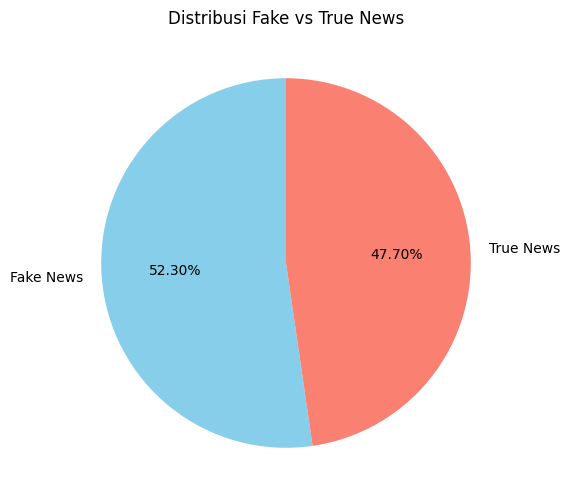

In [ ]:
# Hitung jumlah per label
label_counts = df["label"].value_counts()

# Mapping label ke nama
label_names = label_counts.index.map({0: "True News", 1: "Fake News"})

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(label_counts, labels=label_names,
        autopct="%.2f%%", startangle=90, colors=["skyblue", "salmon"])
plt.title("Distribusi Fake vs True News")
plt.show()

##2.Word Lenght Distribution

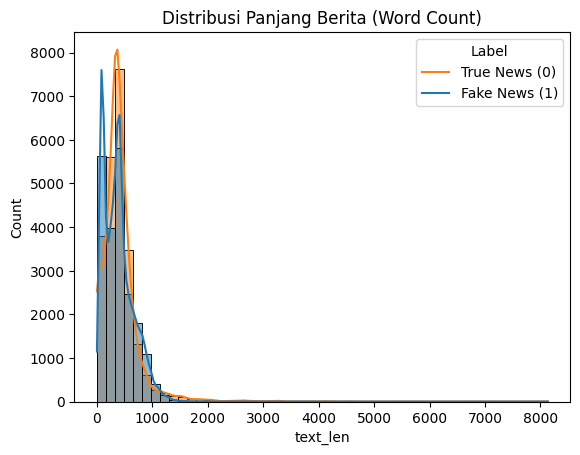

In [ ]:
df["text_len"] = df["text"].apply(lambda x: len(str(x).split()))
ax = sns.histplot(df, x="text_len", hue="label", bins=50, kde=True)
ax.legend(title="Label", labels=["True News (0)", "Fake News (1)"])
plt.title("Distribusi Panjang Berita (Word Count)")
plt.show()

##3.Wordcloud

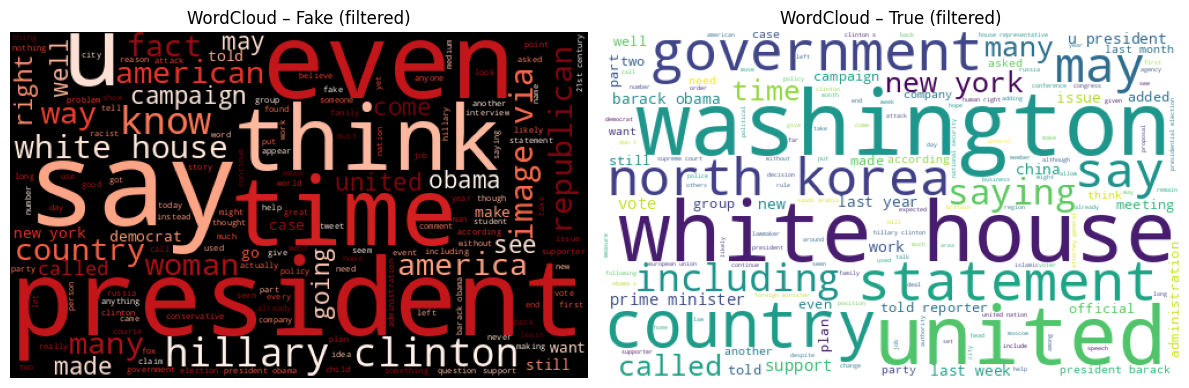

In [ ]:
#jalankan dulu cell di feature engineering bagina deleting
from wordcloud import WordCloud, STOPWORDS

custom_sw = set(STOPWORDS)
custom_sw.update([
    "said","one","people","us","u.s","state","states","trump","donald",
    "percent","monday","tuesday","wednesday","thursday","friday",
    "saturday","sunday","news","report","reuters"
])

fake_text = " ".join(df.loc[df["label"]==1, "clean_text"].astype(str))
true_text = " ".join(df.loc[df["label"]==0, "clean_text"].astype(str))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
wc_fake = WordCloud(width=500, height=300, background_color="black",
                    colormap="Reds", stopwords=custom_sw, max_words=150)
plt.imshow(wc_fake.generate(fake_text)); plt.axis("off"); plt.title("WordCloud – Fake (filtered)")

plt.subplot(1,2,2)
wc_true = WordCloud(width=500, height=300, background_color="white",
                    stopwords=custom_sw, max_words=150)
plt.imshow(wc_true.generate(true_text)); plt.axis("off"); plt.title("WordCloud – True (filtered)")

plt.tight_layout(); plt.show()

##4.Fake VS Trrue Subject News

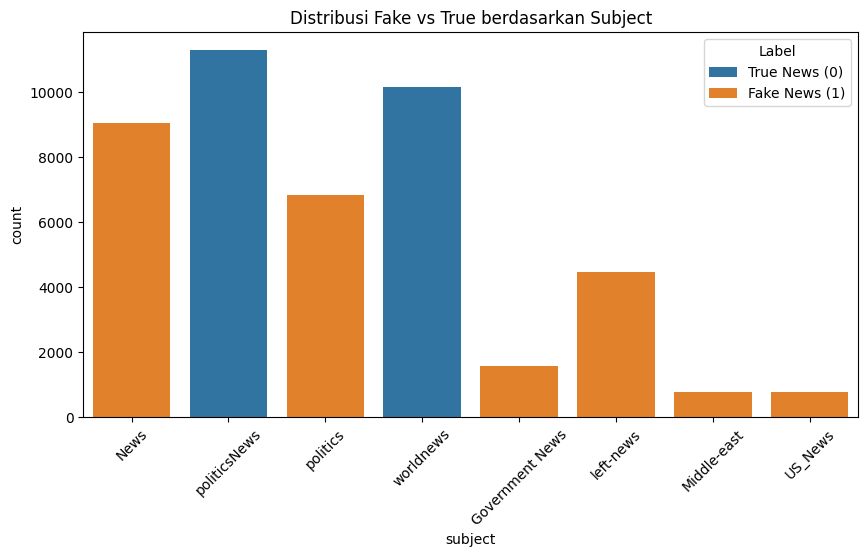

In [ ]:
plt.figure(figsize=(10,5))
ax = sns.countplot(data=df, x="subject", hue="label")
plt.title("Distribusi Fake vs True berdasarkan Subject")
plt.xticks(rotation=45)
ax.legend(title="Label", labels=["True News (0)", "Fake News (1)"])
plt.show()

#Feature Engineering

###1.Deleting (uppercase, tanda baca, stopwords)

In [ ]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()  # lowercase
    text = "".join([ch for ch in text if ch not in string.punctuation])  # hapus tanda baca
    words = text.split()
    words = [word for word in words if word not in stop_words]  # hapus stopwords
    words = [lemmatizer.lemmatize(word) for word in words]      # lemmatizer
    return " ".join(words)

# Terapkan ke kolom text
df["clean_text"] = df["text"].apply(clean_text)

###2.Numeric Feature

In [ ]:
# Panjang teks
df["word_count"] = df["text"].apply(lambda x: len(str(x).split()))
df["char_count"] = df["text"].apply(lambda x: len(str(x)))

# Rata-rata panjang kata
df["avg_word_len"] = df["char_count"] / df["word_count"]

# Jumlah huruf kapital (indikasi sensasional)
df["capital_count"] = df["text"].apply(lambda x: sum(1 for c in str(x) if c.isupper()))

# Jumlah tanda seru (indikasi sensasional)
df["exclamation_count"] = df["text"].apply(lambda x: str(x).count("!"))


###3.TF-IDF Feature

In [ ]:
tfidf = TfidfVectorizer(stop_words="english", max_features=10000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df["clean_text"])

###4.Combine TF-IDF & Numeric Feature

In [ ]:
numeric_features = df[["word_count","char_count","avg_word_len","capital_count","exclamation_count"]]
X = hstack([X_tfidf, numeric_features])
y = df["label"]

###5.Handling Value NaN & ∞

In [ ]:
from scipy.sparse import csr_matrix

# Gabung TF-IDF + numeric
X = hstack([X_tfidf, numeric_features])

# Konversi ke CSR
X = csr_matrix(X)

# Ganti nilai NaN / ∞
X.data[np.isnan(X.data)] = 0
X.data[np.isinf(X.data)] = 0

print("Apakah masih ada NaN?", np.isnan(X.data).sum())
print("Apakah masih ada ∞?", np.isinf(X.data).sum())


Apakah masih ada NaN? 0
Apakah masih ada ∞? 0


In [ ]:
# Ganti inf (tak hingga) dengan NaN
numeric_features = df[["word_count","char_count","avg_word_len","capital_count","exclamation_count"]]
numeric_features = numeric_features.replace([np.inf, -np.inf], np.nan)

# Isi NaN dengan median
numeric_features = numeric_features.fillna(numeric_features.median())

# Gabungkan kembali dengan TF-IDF
from scipy.sparse import hstack
X = hstack([X_tfidf, numeric_features])
y = df["label"]


#Modelling

###1.Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (35918, 10005)
Test shape: (8980, 10005)


In [ ]:
# Cross-validation yang stabil
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n=== {name} | Best params ===")
    if hasattr(model, "best_params_"):
        print(model.best_params_)
    print("\n=== Classification Report ===")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

##2.Model(Logistic Regression)

In [ ]:
log_reg = LogisticRegression(max_iter=2000, solver="liblinear")
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

###Prediksi Test

              precision    recall  f1-score   support

        True       0.99      0.99      0.99      4284
        Fake       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



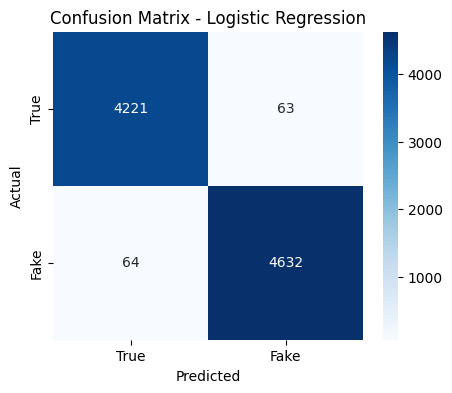

In [ ]:
print(classification_report(y_test, y_pred, target_names=["True", "Fake"]))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["True", "Fake"],
            yticklabels=["True", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

###Prediksi Train

Classification Report (Train)
              precision    recall  f1-score   support

        True       0.99      0.99      0.99     17133
        Fake       0.99      0.99      0.99     18785

    accuracy                           0.99     35918
   macro avg       0.99      0.99      0.99     35918
weighted avg       0.99      0.99      0.99     35918



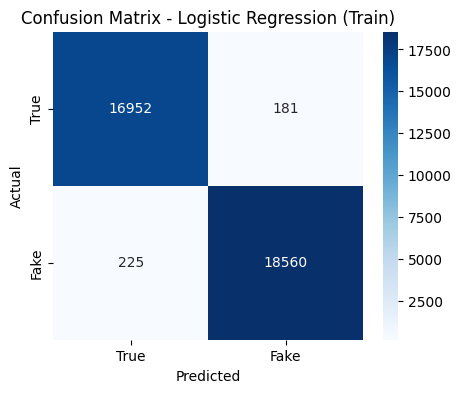

In [ ]:
# Prediksi train
y_pred_train = log_reg.predict(X_train)

print("Classification Report (Train)")
print(classification_report(y_train, y_pred_train, target_names=["True", "Fake"]))

# Confusion Matrix (Train)
cm_train = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(5,4))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues",
            xticklabels=["True", "Fake"],
            yticklabels=["True", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (Train)")
plt.show()

###GridsearchCV(LogReg)

In [ ]:
logreg = LogisticRegression(max_iter=1000, n_jobs=-1)

param_grid_logreg = {
    "C": [0.01, 0.1, 1, 3, 10],
    "penalty": ["l2"],                 # Teks l2
    "solver": ["liblinear", "lbfgs"],  # 'saga'
    "class_weight": [None, "balanced"] # balanced
}

gs_logreg = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid_logreg,
    scoring="f1_macro",
    cv=skf,
    n_jobs=-1,
    verbose=1
)

evaluate_model("Logistic Regression (GridSearch)", gs_logreg, X_train, y_train, X_test, y_test)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(



=== Logistic Regression (GridSearch) | Best params ===
{'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9925    0.9902    0.9914      4284
           1     0.9911    0.9932    0.9921      4696

    accuracy                         0.9918      8980
   macro avg     0.9918    0.9917    0.9917      8980
weighted avg     0.9918    0.9918    0.9918      8980

Confusion Matrix:
 [[4242   42]
 [  32 4664]]


###Probabilitas, ROC/PR, dan tuning threshold

In [ ]:
# Ambil model
clf = (gs_logreg.best_estimator_ if 'gs_logreg' in globals() and hasattr(gs_logreg, 'best_estimator_') else
       rs_logreg.best_estimator_ if 'rs_logreg' in globals() and hasattr(rs_logreg, 'best_estimator_') else
       logreg)

# fit model
try:
    _ = clf.predict(X_test[:1])
except NotFittedError:
    clf.fit(X_train, y_train)

# Probabilitas + metrik kurva
proba = clf.predict_proba(X_test)[:, 1]
print("ROC-AUC :", roc_auc_score(y_test, proba))
prec, rec, thr = precision_recall_curve(y_test, proba)
print("PR-AUC  :", average_precision_score(y_test, proba))

# 4)threshold terbaik untuk F1
f1s = 2*prec*rec/(prec+rec + 1e-12)
best_idx = np.argmax(f1s)
best_t = thr[best_idx-1] if best_idx>0 else 0.5
print("Best threshold (F1):", best_t)

ROC-AUC : 0.9993791525696025
PR-AUC  : 0.9994165638925382
Best threshold (F1): 0.5079492241135295


###learning curve Logistic Regression

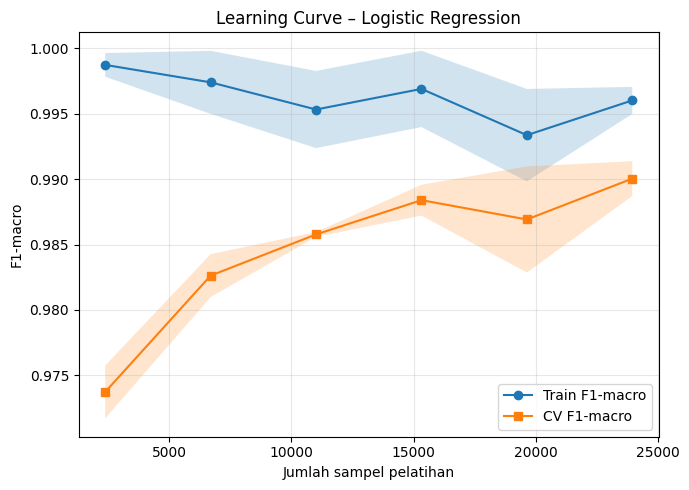

In [ ]:
#CV dan ukuran data latih yang diuji
if 'gs_logreg' in globals() and hasattr(gs_logreg, 'best_estimator_'):
    est = clone(gs_logreg.best_estimator_)
elif 'rs_logreg' in globals() and hasattr(rs_logreg, 'best_estimator_'):
    est = clone(rs_logreg.best_estimator_)
elif 'logreg' in globals():
    est = clone(logreg)
else:
    est = LogisticRegression(C=10, class_weight='balanced', solver='liblinear', max_iter=1000)

# CV & train sizes
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
train_sizes = np.linspace(0.1, 1.0, 6)

#learning curve
sizes, train_scores, val_scores = learning_curve(
    est, X_train, y_train,
    cv=cv, scoring="f1_macro", n_jobs=-1,
    train_sizes=train_sizes, shuffle=True, random_state=42
)

train_mean, train_std = train_scores.mean(1), train_scores.std(1)
val_mean, val_std     = val_scores.mean(1),   val_scores.std(1)

plt.figure(figsize=(7,5))
plt.plot(sizes, train_mean, marker="o", label="Train F1-macro")
plt.fill_between(sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.plot(sizes, val_mean, marker="s", label="CV F1-macro")
plt.fill_between(sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)
plt.title("Learning Curve – Logistic Regression")
plt.xlabel("Jumlah sampel pelatihan"); plt.ylabel("F1-macro")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

In [ ]:
# Model L1 (butuh solver saga/liblinear)
lr_l1 = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    C=10,
    max_iter=1000
)

lr_l1.fit(X_train, y_train)

# Ambil koefisien
coef = lr_l1.coef_[0]
nonzero = np.sum(coef != 0)
print(f"Jumlah fitur dipilih (non-zero coef): {nonzero} dari {X_train.shape[1]}")

Jumlah fitur dipilih (non-zero coef): 747 dari 10005


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold

# evaluasi test
y_pred_l1 = lr_l1.predict(X_test)
print("Acc (test):", accuracy_score(y_test, y_pred_l1))
print("F1  (test):", f1_score(y_test, y_pred_l1, average="macro"))

# evaluasi CV di train
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lr_l1, X_train, y_train, scoring="f1_macro", cv=cv, n_jobs=-1)
print("CV F1 mean±std:", scores.mean(), "±", scores.std())


Acc (test): 0.995879732739421
F1  (test): 0.9958709141843965
CV F1 mean±std: 0.9959266391391486 ± 0.0004532276282734784


###Calibration Curve

Brier score : 0.0080616618152779


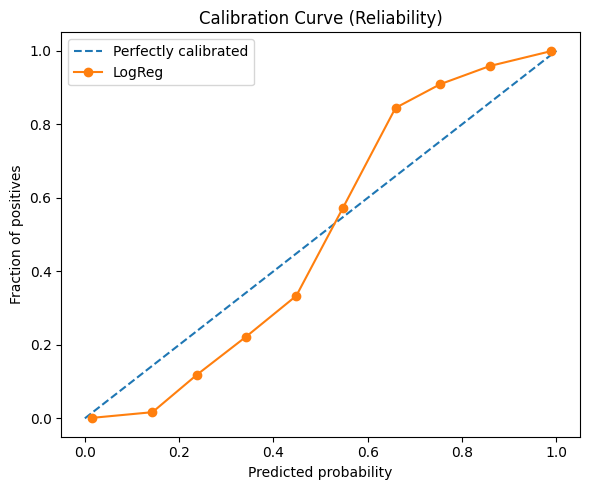

In [ ]:
lr_cal = LogisticRegression(penalty="l2", solver="liblinear", C=8, max_iter=2000, class_weight="balanced").fit(X_train, y_train)

proba_test = lr_cal.predict_proba(X_test)[:,1]  # prob. kelas 'Fake'
frac_pos, mean_pred = calibration_curve(y_test, proba_test, n_bins=10, strategy="uniform")

print("Brier score :", brier_score_loss(y_test, proba_test))

plt.figure(figsize=(6,5))
plt.plot([0,1],[0,1], linestyle="--", label="Perfectly calibrated")
plt.plot(mean_pred, frac_pos, marker="o", label="LogReg")
plt.xlabel("Predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve (Reliability)")
plt.legend()
plt.tight_layout()
plt.show()

###Calibration Curve after platt scaling

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Brier score (raw) : 0.008548
Brier score (cal) : 0.008178


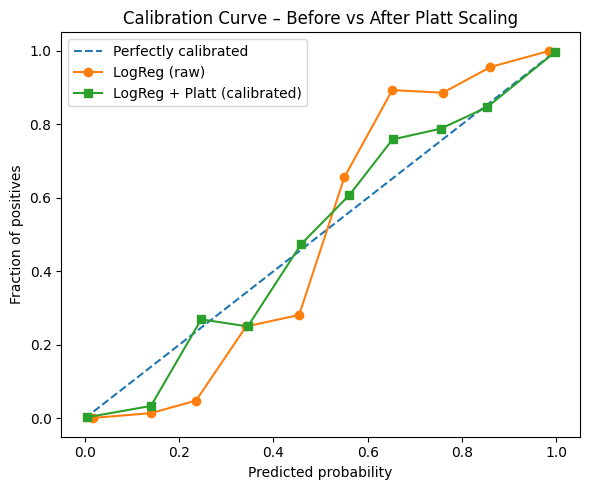

In [ ]:
lr_raw = LogisticRegression(
    penalty="l2", solver="lbfgs", C=3, max_iter=5000, class_weight="balanced"
).fit(X_train, y_train)

proba_raw = lr_raw.predict_proba(X_test)[:, 1]
frac_raw, mean_raw = calibration_curve(y_test, proba_raw, n_bins=10, strategy="uniform")
brier_raw = brier_score_loss(y_test, proba_raw)

# Platt Scaling (sigmoid)
lr_cal = CalibratedClassifierCV(lr_raw, method="sigmoid", cv=3)
lr_cal.fit(X_train, y_train)

proba_cal = lr_cal.predict_proba(X_test)[:, 1]
frac_cal, mean_cal = calibration_curve(y_test, proba_cal, n_bins=10, strategy="uniform")
brier_cal = brier_score_loss(y_test, proba_cal)

print(f"Brier score (raw) : {brier_raw:.6f}")
print(f"Brier score (cal) : {brier_cal:.6f}")

# Plot perbandingan
plt.figure(figsize=(6,5))
plt.plot([0,1],[0,1], "--", label="Perfectly calibrated")
plt.plot(mean_raw, frac_raw, "o-", label="LogReg (raw)")
plt.plot(mean_cal, frac_cal, "s-", label="LogReg + Platt (calibrated)")
plt.xlabel("Predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve – Before vs After Platt Scaling")
plt.legend()
plt.tight_layout()
plt.show()

##3.Naive Bayes

###Prediction Test

In [ ]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)

print(classification_report(y_test, y_pred_nb, target_names=["True", "Fake"]))

cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(5,4))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Greens",
            xticklabels=["True", "Fake"],
            yticklabels=["True", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

###Prediction Train

Classification Report (Train) – Naive Bayes
              precision    recall  f1-score   support

        True       0.85      0.95      0.90     17133
        Fake       0.95      0.85      0.90     18785

    accuracy                           0.90     35918
   macro avg       0.90      0.90      0.90     35918
weighted avg       0.90      0.90      0.90     35918



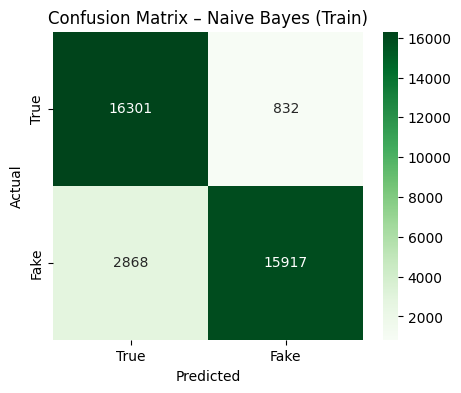

In [ ]:
y_pred_nb_train = nb.predict(X_train)

print("Classification Report (Train) – Naive Bayes")
print(classification_report(y_train, y_pred_nb_train, target_names=["True", "Fake"]))

cm_nb_train = confusion_matrix(y_train, y_pred_nb_train)
plt.figure(figsize=(5,4))
sns.heatmap(cm_nb_train, annot=True, fmt="d", cmap="Greens",
            xticklabels=["True","Fake"], yticklabels=["True","Fake"])
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Confusion Matrix – Naive Bayes (Train)")
plt.show()

###Gridsearch CV Naive BAyes

In [ ]:
mnb = MultinomialNB()

param_grid_mnb = {
    "alpha": [0.01, 0.05, 0.1, 0.5, 1.0, 2.0]
}

gs_mnb = GridSearchCV(
    estimator=mnb,
    param_grid=param_grid_mnb,
    scoring="f1_macro",
    cv=skf,
    n_jobs=-1,
    verbose=1
)

evaluate_model("MultinomialNB (GridSearch)", gs_mnb, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits

=== MultinomialNB (GridSearch) | Best params ===
{'alpha': 0.01}

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.8656    0.9528    0.9071      4284
           1     0.9526    0.8650    0.9067      4696

    accuracy                         0.9069      8980
   macro avg     0.9091    0.9089    0.9069      8980
weighted avg     0.9111    0.9069    0.9069      8980

Confusion Matrix:
 [[4082  202]
 [ 634 4062]]


##4.Linear SVM

###Test Prediction

              precision    recall  f1-score   support

        True       0.98      0.98      0.98      4284
        Fake       0.98      0.98      0.98      4696

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



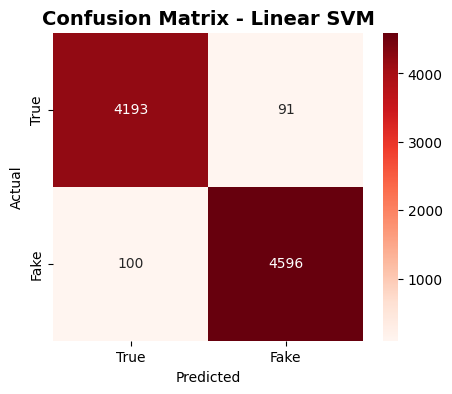

In [ ]:
svm = LinearSVC()
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

print(classification_report(y_test, y_pred_svm, target_names=["True", "Fake"]))

cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(5,4))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Reds",
            xticklabels=["True", "Fake"],
            yticklabels=["True", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Linear SVM", fontsize=14, fontweight="bold")
plt.show()

###Train Prediction

Classification Report (Train) – Linear SVM
              precision    recall  f1-score   support

        True       0.98      0.98      0.98     17133
        Fake       0.98      0.98      0.98     18785

    accuracy                           0.98     35918
   macro avg       0.98      0.98      0.98     35918
weighted avg       0.98      0.98      0.98     35918



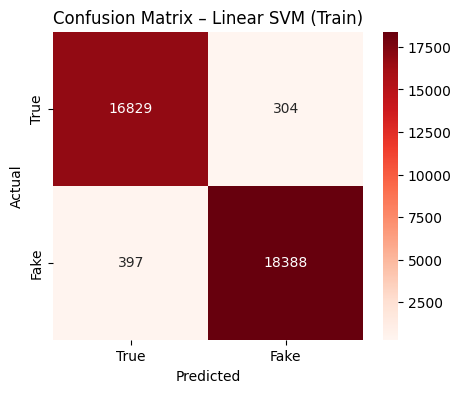

In [ ]:
y_pred_svm_train = svm.predict(X_train)

print("Classification Report (Train) – Linear SVM")
print(classification_report(y_train, y_pred_svm_train, target_names=["True", "Fake"]))

cm_svm_train = confusion_matrix(y_train, y_pred_svm_train)
plt.figure(figsize=(5,4))
sns.heatmap(cm_svm_train, annot=True, fmt="d", cmap="Reds",
            xticklabels=["True","Fake"], yticklabels=["True","Fake"])
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Confusion Matrix – Linear SVM (Train)")
plt.show()

###GridSearchCV(LinearSVC)

In [ ]:
lsvc = LinearSVC()

param_grid_lsvc = {
    "C": [0.01, 0.1, 1, 3, 10],
    "loss": ["hinge", "squared_hinge"],
    "class_weight": [None, "balanced"]
}

gs_lsvc = GridSearchCV(
    estimator=lsvc,
    param_grid=param_grid_lsvc,
    scoring="f1_macro",
    cv=skf,
    n_jobs=-1,
    verbose=1
)

evaluate_model("LinearSVC (GridSearch)", gs_lsvc, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

=== LinearSVC (GridSearch) | Best params ===
{'C': 1, 'class_weight': 'balanced', 'loss': 'squared_hinge'}

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9937    0.9937    0.9937      4284
           1     0.9943    0.9943    0.9943      4696

    accuracy                         0.9940      8980
   macro avg     0.9940    0.9940    0.9940      8980
weighted avg     0.9940    0.9940    0.9940      8980

Confusion Matrix:
 [[4257   27]
 [  27 4669]]


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, solver="liblinear"),
    "Linear SVM": LinearSVC(),
    "Naive Bayes": MultinomialNB(),
}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=skf, scoring="f1")
    print(f"{name} | Mean F1: {scores.mean():.4f} | Std: {scores.std():.4f}")


Logistic Regression | Mean F1: 0.9856 | Std: 0.0025
Linear SVM | Mean F1: 0.9875 | Std: 0.0015
Naive Bayes | Mean F1: 0.8947 | Std: 0.0034
